In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

In [13]:
%autoreload

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [10,10]


from astropy.io import fits

import numpy as np
import copy
import pickle

import darkhistory.physics as phys
import darkhistory.utilities as utils
import darkhistory.spec.spectools as spectools
import darkhistory.spec.transferfunction as tf
from darkhistory.spec.spectrum import Spectrum
from darkhistory.spec.spectra import Spectra
import darkhistory.history.tla as tla

from scipy.interpolate import interp1d

from tqdm import tqdm_notebook as tqdm

from darkhistory.electrons.ics.ics_spectrum import ics_spec
from darkhistory.electrons.ics.ics_engloss_spectrum import engloss_spec
from darkhistory.electrons.ics.ics_cooling import get_ics_cooling_tf

import darkhistory.low_energy.lowE_photons as lowE_photons
import darkhistory.low_energy.lowE_electrons as lowE_electrons
import darkhistory.low_energy.lowE_deposition as lowE_deposition

import scipy.interpolate

# np.set_printoptions(threshold=np.nan)

In [14]:
user = 'hongwan'

highengphot_tflist_arr_raw = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tfunclist_photspec_60eV_list_new_fixed_binning.raw", "rb"))
lowengphot_tflist_arr_raw  = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tfunclist_lowengphotspec_60eV_list_new_fixed_binning.raw", "rb"))
lowengelec_tflist_arr_raw  = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tfunclist_lowengelecspec_60eV_list_new_fixed_binning.raw", "rb"))
CMB_engloss_raw = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/CMB_engloss_60eV_list_new_fixed_binning.raw", "rb"))

In [15]:
tflist_xe_ind = 0
# Note that for now, highengphot_tflist_arr_raw only has one entry, and in actual fact has an ionization
# corresponding to 0.5 + 0.5*np.tanh(-4.1). But we set this to 0 here instead of 1 to access the single element
# in the array.

print(0.5 + 0.5*np.tanh([-5., -4.1, -3.2, -2.3, -1.4, -0.5, 0.4, 1.3, 2.2, 3.1, 4]))


highengphot_tflist_arr = [highengphot_tflist_arr_raw[tflist_xe_ind]]
lowengphot_tflist_arr  = [lowengphot_tflist_arr_raw[tflist_xe_ind]]
lowengelec_tflist_arr  = [lowengelec_tflist_arr_raw[tflist_xe_ind]]
CMB_engloss_arr = CMB_engloss_raw[0]

[4.53978687e-05 2.74578156e-04 1.65880108e-03 9.95180187e-03
 5.73241759e-02 2.68941421e-01 6.89974481e-01 9.30861580e-01
 9.87871565e-01 9.97974680e-01 9.99664650e-01]


In [16]:
eng_ind = 95
eng_exp = {95: 3.884, 195: 6.077, 295: 8.271, 395: 10.46, 495: 12.66}[eng_ind]


# Check that this matches with the input 

# file_name = {99: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_5.328E+00_xe_1.000E-04.fits",
#             199: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_7.183E+00_xe_1.000E-04.fits",
#             298: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_9.020E+00_xe_1.000E-04.fits",
#             299: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_9.038E+00_xe_1.000E-04.fits", 
#             399: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_1.089E+01_xe_1.000E-04.fits",
#             499: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_1.275E+01_xe_1.000E-04.fits",
#             2993: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_18_logE_9.038E+00_xe_1.000E-04.fits"}

# file_name = {95: "/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_3.884E+00_xe_2.746E-04.fits",
#             195: "/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_6.077E+00_xe_2.746E-04.fits",
#             295: "/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_8.271E+00_xe_2.746E-04.fits",
#             395: "/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_1.046E+01_xe_2.746E-04.fits", 
#             495: "/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_1.266E+01_xe_2.746E-04.fits"}

file_name = {95: "/Users/"+user+"/Dropbox (MIT)/Photon Deposition/fixed_binning_data/tf_z_3.100E+01_nstep_2049_logE_3.884E+00_xe_2.746E-04.fits",
            195: "/Users/"+user+"/Dropbox (MIT)/Photon Deposition/fixed_binning_data/tf_z_3.100E+01_nstep_2049_logE_6.077E+00_xe_2.746E-04.fits",
            295: "/Users/"+user+"/Dropbox (MIT)/Photon Deposition/fixed_binning_data/tf_z_3.100E+01_nstep_2049_logE_8.271E+00_xe_2.746E-04.fits",
            395: "/Users/"+user+"/Dropbox (MIT)/Photon Deposition/fixed_binning_data/tf_z_3.100E+01_nstep_2049_logE_1.046E+01_xe_2.746E-04.fits", 
            495: "/Users/"+user+"/Dropbox (MIT)/Photon Deposition/fixed_binning_data/tf_z_3.100E+01_nstep_2049_logE_1.266E+01_xe_2.746E-04.fits"}


file = fits.open(file_name[eng_ind])

file_eng     = file[1].data['energy'][0,:]
file_eleceng = file[1].data['eleceng'][0,:]
file_rs      = file[1].data['redshift'][0,:]

file_photonspectrum = file[1].data['photonspectrum'][0,:,:]
file_lowengphot     = file[1].data['lowengphot'][0,:,:]
file_lowengelec     = file[1].data['lowengelec'][0,:,:]
file_cmbloss        = file[1].data['cmblosstable'][0,:]

file_photeng_bin_bound = spectools.get_bin_bound(file_eng)
file_eleceng_bin_bound = spectools.get_bin_bound(file_eleceng)

file_photeng_bin_width = np.diff(file_photeng_bin_bound)
file_eleceng_bin_width = np.diff(file_eleceng_bin_bound)

In [17]:
mwimp = file[1].data['mwimp'][0]
eleceng = lowengelec_tflist_arr[0].eng
photeng = highengphot_tflist_arr[0].eng

eng_bin_to_find = file_eng[file_eng < mwimp][-1]

fac = mwimp/eng_bin_to_find

phot_spec_init = spectools.rebin_N_arr(np.array([2*fac]), 
                                      np.array([eng_bin_to_find]), 
                                      photeng)

phot_spec_init.switch_spec_type()

In [18]:
#Split photeng into high and low energy. 
photeng_high = photeng[photeng > 60]
photeng_low  = photeng[photeng <= 60]

# Split eleceng into high and low energy. 
eleceng_high = eleceng[eleceng > 3000]
eleceng_low  = eleceng[eleceng <= 3000]


for highengphot_tflist in highengphot_tflist_arr:
    
#     highengphot_tflist.at_val('in_eng', photeng_high, bounds_error=False, fill_value=0)

    for tf in highengphot_tflist:
        # tf.rebin(photeng_high)
#         tf.rebin(photeng)
        
        # Pad with zeros so that it becomes photeng x photeng. 
        tf._grid_vals = np.pad(tf.grid_vals, ((photeng_low.size, 0), (0, 0)), 'constant')
        tf._N_underflow = np.pad(tf._N_underflow, (photeng_low.size, 0), 'constant')
        tf._eng_underflow = np.pad(tf._eng_underflow, (photeng_low.size, 0), 'constant')
        tf._in_eng = photeng
        tf._eng = photeng
        tf._rs = tf.rs[0]*np.ones_like(photeng)
    
    highengphot_tflist._eng = photeng
    highengphot_tflist._in_eng = photeng
    
# lowengphot_tflist.in_eng set to photeng_high
for lowengphot_tflist in lowengphot_tflist_arr:
    
#     lowengphot_tflist.at_val('in_eng', photeng_high, bounds_error=False, fill_value=0)
    
    for tf in lowengphot_tflist:
#         tf.rebin(photeng)
        # Pad with zeros so that it becomes photeng x photeng. 
        tf._grid_vals = np.pad(tf.grid_vals, ((photeng_low.size,0), (0,0)), 'constant')
        # Photons in the low energy bins should be immediately deposited.
        tf._grid_vals[0:photeng_low.size, 0:photeng_low.size] = np.identity(photeng_low.size)
        tf._N_underflow = np.pad(tf._N_underflow, (photeng_low.size, 0), 'constant')
        tf._eng_underflow = np.pad(tf._eng_underflow, (photeng_low.size, 0), 'constant')
        tf._in_eng = photeng
        tf._eng = photeng
        tf._rs = tf.rs[0]*np.ones_like(photeng)
    
    lowengphot_tflist._eng = photeng
    lowengphot_tflist._in_eng = photeng
    
# lowengelec_tflist.in_eng set to photeng_high 
for lowengelec_tflist in lowengelec_tflist_arr:
    
#     lowengelec_tflist.at_val('in_eng', photeng_high, bounds_error=False, fill_value=0)
    
    for tf in lowengelec_tflist:
#         tf.rebin(eleceng)
        # Pad with zeros so that it becomes photeng x eleceng. 
        tf._grid_vals = np.pad(tf.grid_vals, ((photeng_low.size,0), (0,0)), 'constant')
        tf._N_underflow = np.pad(tf._N_underflow, (photeng_low.size, 0), 'constant')
        tf._eng_underflow = np.pad(tf._eng_underflow, (photeng_low.size, 0), 'constant')
        tf._in_eng = photeng
        tf._eng = eleceng
        tf._rs = tf.rs[0]*np.ones_like(photeng)

    lowengelec_tflist._eng = eleceng
    lowengelec_tflist._in_eng = photeng
    
CMB_engloss_arr = np.pad(CMB_engloss_arr, ((0,0),(photeng_low.size, 0)), 'constant')


In [20]:
print(CMB_engloss_arr.shape)
print(lowengelec_tflist.rs)

(51, 500)
[31.         29.75607604 28.56206648 27.41596845 26.31585941 25.25989399
 24.24630085 23.27337973 22.3394986  21.44309094 20.58265304 19.75674158
 18.96397112 18.20301182 17.47258722 16.77147206 16.09849025 15.45251291
 14.83245642 14.23728068 13.6659873  13.11761798 12.59125283 12.08600893
 11.60103873 11.13552873 10.68869805 10.25979715  9.84810659  9.45293576
  9.07362178  8.70952837  8.36004479  8.02458479  7.70258565  7.39350723
  7.09683108  6.81205952  6.53871487  6.27633861  6.02449061  5.78274841
  5.5507065   5.32797563  5.11418219  4.90896755  4.71198748  4.52291154
  4.34142257  4.16721613  4.        ]


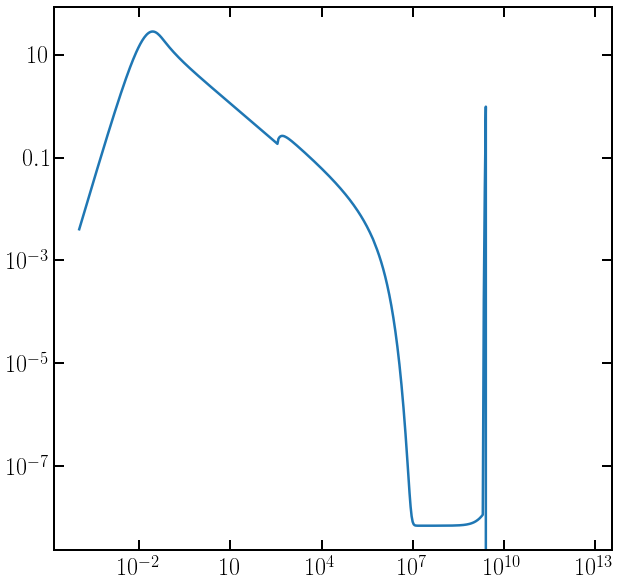

In [31]:
plt.figure()

a = highengphot_tflist[0]

ax = plt.gca()
a.plot(ax, ind=400)

ax.set_xscale('log')
ax.set_yscale('log')

53018.332662243854
4.724426065777819
31.0
5.15765849555985
240642.00740757317
240642.04314392837
1.337973353603412 5.157658495559851


[0.0001, 1000.0, 1e-10, 1000.0]

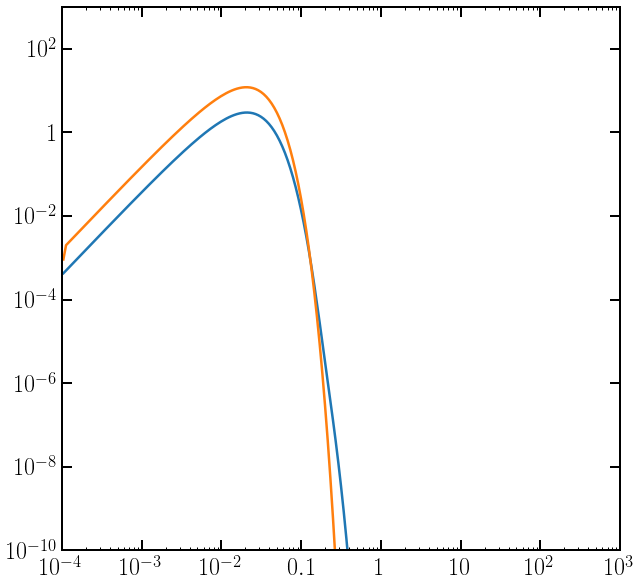

In [85]:
plt.figure()

i = 260

in_eng = lowengphot_tflist[0][i].in_eng

eng = lowengphot_tflist[0][i].eng
rs  = lowengphot_tflist[0][i].rs

print(in_eng)
print(np.log10(in_eng))
print(rs)

plt.plot(eng, lowengphot_tflist[0][i].N)

ax = plt.gca()

ax.set_xscale('log')
ax.set_yscale('log')

cmbloss=CMB_engloss_arr[0,i]
dt = 0.002/phys.hubble(rs)
print(cmbloss*dt)

test = spectools.discretize(eng, phys.CMB_spec, phys.TCMB(rs))

print(test.toteng())
print(phys.CMB_eng_density(phys.TCMB(rs)))

test *= cmbloss*dt/test.toteng()

plt.plot(eng, test.N)

print(lowengphot_tflist[0][i].toteng(), test.toteng())

plt.axis([1e-4, 1e3, 1e-10, 1e3])

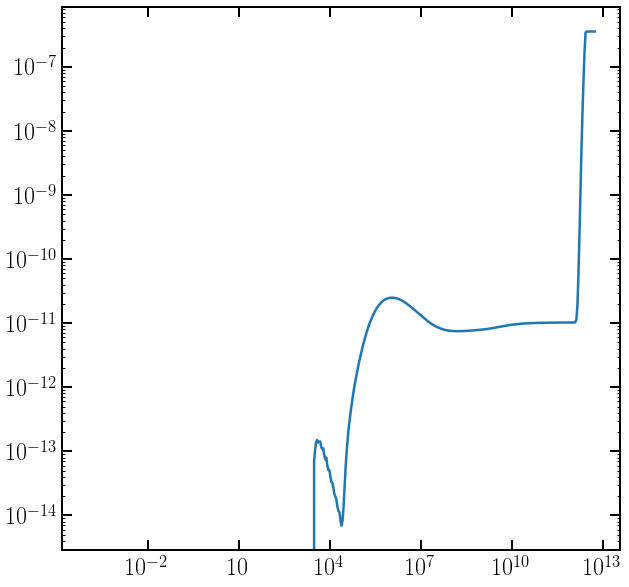

In [61]:
plt.figure()

plt.plot(lowengphot_tflist.in_eng, CMB_engloss_arr[0,:])

ax = plt.gca()

ax.set_xscale('log')
ax.set_yscale('log')

In [89]:
phys.hubble(31.26)

2.1492235652947946e-16